<h4>Load in the data and libraries<h4>

In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')


In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence_new.ipynb', 'adult.data', 'adult.test', 'adult_influence.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence.ipynb', 'config.json', 'expl.py', 'functions.py', 'german.data', 'german_influence.ipynb', 'german_influence_copy.ipynb', 'influence.py', 'load_dataset.py', 'loss.py', 'metrics.py', 'random_influence.ipynb', 'sqf_influence.ipynb', 'sqf_test.csv', 'sqf_train.csv', 'utils.py', '__pycache__']


In [3]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('frisked')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['frisked'] = changed_df_labels

    return y_predicted


<h3>Leave One Out Training INF Calc<h3>

In [4]:
#list of solution times
sol_time = []

In [5]:
dataset = 'sqf'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [6]:
X_train, X_test, y_train, y_test = load(dataset)

In [7]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [8]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
predictors = ['race', 'build', 'age', 'ht_feet', 'weight', 'perobs', 'cs_objcs',
       'cs_descr', 'cs_casng', 'cs_lkout', 'cs_drgtr', 'cs_vcrim', 'ac_proxm',
       'inout_I', 'inout_O', 'sex_F', 'sex_M']
target_var = ['frisked']

In [10]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
#train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [11]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [12]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.06874626497856756
Initial TPR parity:  -0.06270783144277586
Initial predictive parity:  -0.07477904554118925
Initial accuracy:  0.6829706361471952


<h5>Calculate the Influence of each of the datapoints<h5>

In [13]:
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [14]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 48605/48605 [04:41<00:00, 172.85it/s]


In [13]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [14]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [ ]:
#negative of inverse
negative_hinv_v = -1 * hinv_v

In [15]:
inf = np.matmul(np.transpose(negative_hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [ ]:
inf = (-1/(len(X_train))) *inf 

In [ ]:
decimal_array = [format(num, '.10f') for num in inf]
decimal_array = [float(num) for num in decimal_array]

<h5>Leave One Out Training<h5>

In [ ]:
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    parity = parity-spd_0

    difference.append(parity)
    print(index)
#This does not fall under the measuring the time taken to decide how long it will take for IF to work 

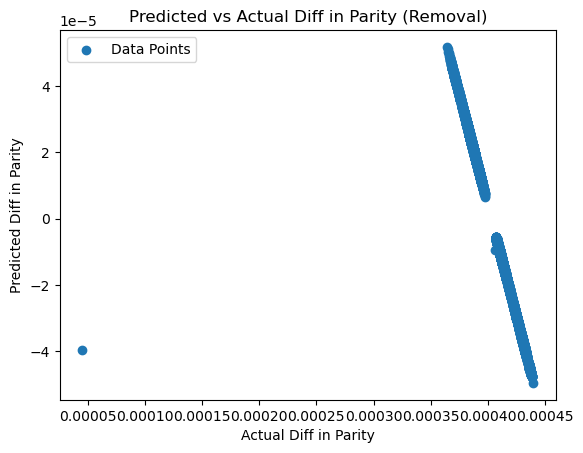

In [ ]:
#fix the sacles here and I will get the graph I hopefully want
predicted_diff = decimal_array
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the limits for both axes to be the same
#plt.xlim(0.0010, 0.0015)  # Adjust these values as needed
#plt.ylim(-0.00015, 0.00015)  # Adjust these values as needed

# Set the aspect ratio of the plot to be equal
#plt.gca().set_aspect('equal', adjustable='box')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h3>INF Calc on Flipped Labels and Compare them to flipping the datapoints<h3>

In [16]:
flipping_time_start = time.time()
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})
#y_test_changed = y_test.replace({0:1,1:0})

In [17]:
#Run the Classifiers and calculate the statistical parity after changing everything
#In theory it shouldnt change anything but uhhhh lets see 
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [18]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train_changed)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_1)

tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_1)

predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_1)

accuracy_1 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_1)

Initial statistical parity:  0.06832083893440899
Initial TPR parity:  0.0622846366917561
Initial predictive parity:  -0.07730164684766444
Initial accuracy:  0.3171129025521073


In [19]:
#Original datapoints before changing the datapoints
metric_val = [spd_1, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta2 = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [20]:
hessian_all_points2 = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 48605/48605 [03:44<00:00, 216.74it/s]


In [21]:
del_L_del_theta2 = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [22]:
hinv_v2, hinv2 = get_hinv_v(hessian_all_points2, np.transpose(del_L_del_theta2))
#incorporate del_l_del_theta_i with the updated datapoint

In [23]:
inf2 = np.matmul(np.transpose(hinv_v2), del_F_del_theta2)
#For the new datapoint re-calculate the hinv_v

In [ ]:
negative_hinv_v_2 = -1 * hinv_v2

In [ ]:
inf2 = (-1/(len(X_train))) *inf2 

In [ ]:
#Flipping
#Make the original flips to test for the parity after each flip 
actual_df_train = train_full_df.copy()
actual_parity_list = []

for index, row in actual_df_train.iterrows():
    if row['frisked'] == 1:
        #Flip the label at income = 1 to 0
        actual_df_train.at[index,'frisked'] = 0
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'frisked'] = 1
        
    elif row['frisked'] == 0:
        actual_df_train.at[index,'frisked'] = 1
        actual_pred = lr_model(actual_df_train, X_test, clf)
        actual_parity = computeFairness(actual_pred, X_test_orig, y_test, 0, dataset)
        actual_parity_list.append(actual_parity)
        actual_df_train.at[index,'frisked'] = 0

In [ ]:
decimal_array = [format(num, '.10f') for num in inf2]
decimal_array = [float(num) for num in decimal_array]

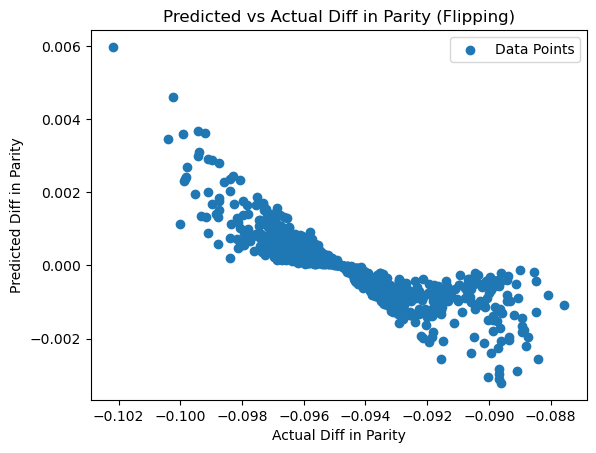

In [ ]:
predicted_diff = decimal_array
actual_diff = actual_parity_list

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Flipping)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


<h4>Calculate the difference between the changed vs original<h4>

<h5>Implement Solutions<h5>
<li>Influence</li>
<li>Entropy</li>
<li>Randomized</li>


<h5>Influence Based Flips<h5>

In [37]:
if_start = time.time()
index_list = []
for i in range(len(X_train)):
    index_list.append(i)

In [38]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [39]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(inf2, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)
#Measure up to here for the influence functions
#This will tell us how long it takes for influence functions to determine which order I need to flip the datapoints in
#if_time: Time taken to decide the order in which the datapoints need to be flipped
flipping_time_end = time.time() - flipping_time_start
print(flipping_time_end)

-237.45708918571472


In [40]:
if flipping_time_end < 0:
    flipping_time_end = -1 * flipping_time_end
else: 
    pass

In [ ]:
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'frisked'] == 1:
        influence_train_copy.at[row_num,'frisked'] = 0
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
        print(i)
    elif influence_train_copy.at[row_num,'frisked'] == 0:
        influence_train_copy.at[row_num,'frisked'] = 1
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
        print(i)

In [42]:
sol_time.append(flipping_time_end)

<h5>Uncertainty Reduction/Entropy<h5>

In [43]:
entropy_start = time.time()
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [44]:
#Run the LR classifier
#Use Scikit learn logistic regression rather than pre-built one
clfa = LogisticRegression(class_weight=None, max_iter=100)
log = clfa.fit(X_train,y_train)
prediction = log.predict(X_test)
#prediction_prob = log.predict_proba(X_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

68.3304790944405


In [45]:
#Obtain the predicted probabilities
predicted_prob = log.predict_proba(X_train)

In [46]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_prob):
  #Calculate p1 and p2
  p1=predicted_prob[index,0]
  p2=predicted_prob[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [47]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)
entropy_end = time.time()

In [48]:
entropy_train_df['frisked'] = entropy_train_df['frisked'].astype('int')

In [49]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [50]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

ranked_ent_parity_list = [spd_0]
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'frisked'] == 0:
        entropy_train_df.at[row_num,'frisked'] = 1
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'frisked'] == 1:
        entropy_train_df.at[row_num,'frisked'] = 0
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

In [51]:
entropy_time = entropy_end - entropy_start
sol_time.append(entropy_time)

<h5>Randomized<h5>

In [52]:
#Training dataset
random_start = time.time()
random_training_df = train_full_df.copy()

In [53]:
#Budget of 200 random flipping
import random
random_flip_parity = []
budget = len(y_test)

for iter in range(budget):
    random_row = random.choice(random_training_df.index)
    if random_training_df.at[random_row,'frisked'] == 1:
        random_training_df.at[random_row,'frisked'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[random_row,'frisked'] == 0:
        random_training_df.at[random_row,'frisked'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
random_end = time.time()


In [54]:
random_time = random_end - random_start
sol_time.append(random_time)

<h5>Graph Time and Parity<h5>

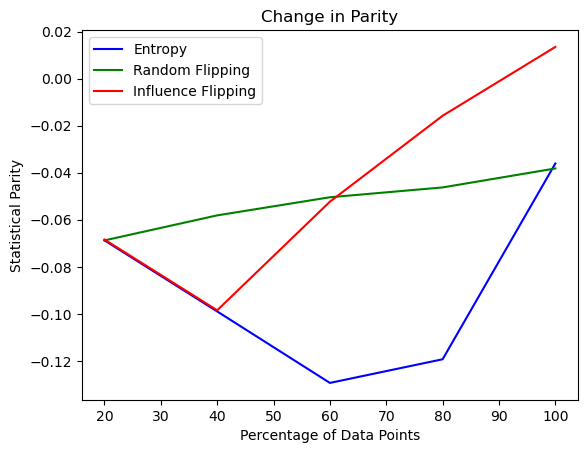

In [55]:
# Calculate the total number of data points
datapoints_entropy = len(ranked_ent_parity_list)
datapoints_random = len(random_flip_parity)
datapoints_influence = len(flip_parity_abs)

# Calculate the indices for the 5 points
indices_entropy = [int(i * datapoints_entropy / 5) for i in range(0, 5)]
indices_random = [int(i * datapoints_random / 5) for i in range(0, 5)]
indices_influence = [int(i * datapoints_influence / 5) for i in range(0, 5)]

# Extract the values at these indices
values_entropy = [ranked_ent_parity_list[index] for index in indices_entropy]
values_random = [random_flip_parity[index] for index in indices_random]
values_influence = [flip_parity_abs[index] for index in indices_influence]

# Plot the values
plt.plot([20, 40, 60, 80, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([20, 40, 60, 80, 100], values_random, label='Random Flipping', color='Green')
plt.plot([20, 40, 60, 80, 100], values_influence, label='Influence Flipping', color='Red')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Statistical Parity')
plt.title('Change in Parity')
plt.legend()

<h4>Time Comparisons<h4>

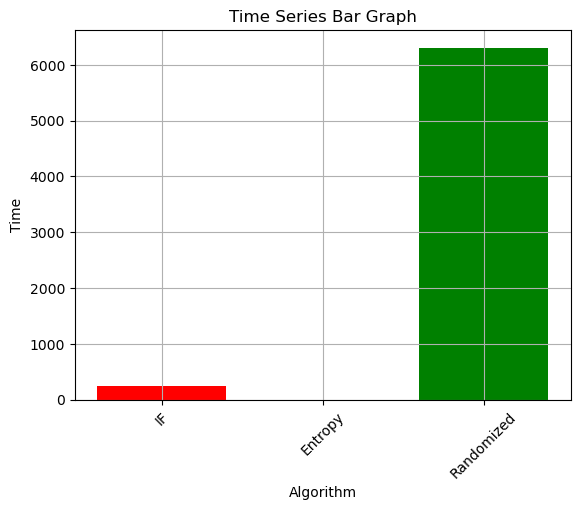

In [56]:
# Create a line chart
x_axis = ['IF', 'Entropy', 'Randomized']
# Colors for each bar
colors = ['red', 'blue', 'green']

# Create a bar graph with updated labels and colors
plt.bar(x_axis, sol_time, color=colors)
plt.title('Time Series Bar Graph')
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [57]:
print(predicted_diff)
print(actual_diff)
print(sol_time)

[-3.8e-09, 3.9e-09, -5.8e-09, 6.1e-09, 3.6e-09, 1.81e-08, 6.8e-09, 1.28e-08, 2.53e-08, -1.61e-08, -1.4e-09, 5.69e-08, -1.15e-08, 1.29e-08, -3e-09, 1.93e-08, 1.02e-08, 6.9e-09, -1.2e-09, 4e-09, 2.18e-08, 3.9e-09, 6e-09, -2.29e-08, -4.26e-08, -8.4e-09, 3.39e-08, -9e-09, 1.29e-08, 2e-08, -2.1e-09, -1.26e-08, -1.04e-08, 2.89e-08, -1.08e-08, -3.5e-09, 2.76e-08, -1.93e-08, 9.3e-09, 1.28e-08, 1.2e-08, -1.29e-08, 7.3e-09, -9e-09, 3.39e-08, 1.04e-08, 2.4e-09, 1.85e-08, 1.58e-08, 3.09e-08, 5e-10, 2.3e-09, -1.14e-08, 7e-10, -1.08e-08, -1.06e-08, -1.3e-09, 1.2e-08, 1.2e-08, 1.5e-08, -1.86e-08, 1.2e-09, -7.4e-09, 3.06e-08, 2.36e-08, -5.1e-09, -1.2e-09, 1.2e-08, 1.5e-08, 6e-10, -1.49e-08, 7.8e-09, -2e-10, 2.89e-08, 2.18e-08, 2.6e-08, -5e-10, 2.11e-08, -1.7e-09, -5.24e-08, -5e-10, 4.42e-08, 4.8e-09, -3.6e-09, -8.5e-09, 1.16e-08, -3e-09, 6.1e-09, 3e-10, 3.9e-09, 1.75e-08, -1.4e-09, -4.2e-09, 2.52e-08, 1e-09, 5.4e-09, 6.1e-09, 2.18e-08, -7e-10, 8.8e-09, 9e-09, 1.21e-08, 5e-10, -5.4e-09, 1.39e-08, 1.58e